## Example: Blackjack
See the full example [here](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/).

**Game**
This version of the game uses an infinite deck (we draw the cards with replacement), so counting cards won’t be a viable strategy in our simulated game.

**Objective**
To win, your card sum should be greater than the dealers without exceeding 21.

**Actions**
- stand (0): take no more cards
- hit(1): the player will be given another card, however the player could get over 21 and bust

In [1]:
import gymnasium as gym 

In [2]:
env = gym.make("Blackjack-v1", sab=True) # sab means Sutton and Barto rules

In [3]:
done = False # start the episode
observation, info = env.reset() # reset at the start of the episode
print(observation)

(15, 8, 0)


**Observation** is a triple of the form (`player hand value`, `dealer face up value`, `usable ace`).

*Usable Ace* is a boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

### Actions
The environment function `env.step(action)` executes an action. This returns the following:
- `next_state`: This is the observation that the agent will receive after taking the action.
- `reward`: This is the reward that the agent will receive after taking the action.
- `terminated`: This is a boolean variable that indicates whether or not the environment has terminated.
- `truncated`: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
- `info`: This is a dictionary that might contain additional information about the environment.

In [4]:
observation, info = env.reset()
print(observation)
action = env.action_space.sample()
print(f"Player taking action {action}")
observation, reward, done, truncated, info = env.step(action=action)
print(observation, reward, done)

(20, 5, 0)
Player taking action 0
(20, 5, 0) -1.0 True


### Q-learning Agent
This agent uses an $\epsilon$-greedy strategy, where
$$
\pi(s) = \left\{ \begin{matrix}
\textrm{random}\ a & \textrm{with probability} & \epsilon \\
\arg\max\limits_{a} Q(s, a) & \textrm{with probability} & 1-\epsilon
\end{matrix} \right .
$$

#### Implementation
<img src="../imgs/bj-agent.png" style="width: 60%;">

In [5]:
from mdp.blackjack import BlackJackAgent

In [6]:
learning_rate = 0.001
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
env = gym.make("Blackjack-v1", sab=True) # sab means Sutton and Barto rules

agent = BlackJackAgent(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

#### Training
We update the Q values after each episode. Note the use of the `RecordEpisodeStatistics` wrapper.

In [7]:
from tqdm.notebook import tqdm

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    # play a game
    while not done:
        action = agent.policy(state)
        s_prime, reward, terminated, truncated, info = env.step(action=action)
        # update
        agent.update(state, action, reward, terminated, s_prime)
        done = terminated or truncated
        state = s_prime
    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

#### Visualize training stats

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid")

**Convolution**: use convolution to show data

In [10]:
a = np.array([-1, 1, 0, 1, 1, 1, 1, 1, 1])
b = np.ones(2)
np.convolve(a, b, mode='valid') / 2

array([0. , 0.5, 0.5, 1. , 1. , 1. , 1. , 1. ])

In [11]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [12]:
w = 500
rewards = conv(np.array(env.return_queue).flatten(), win=w)
lengths = conv(np.array(env.length_queue).flatten(), win=w)
error = conv(np.array(agent.training_error), win=w)

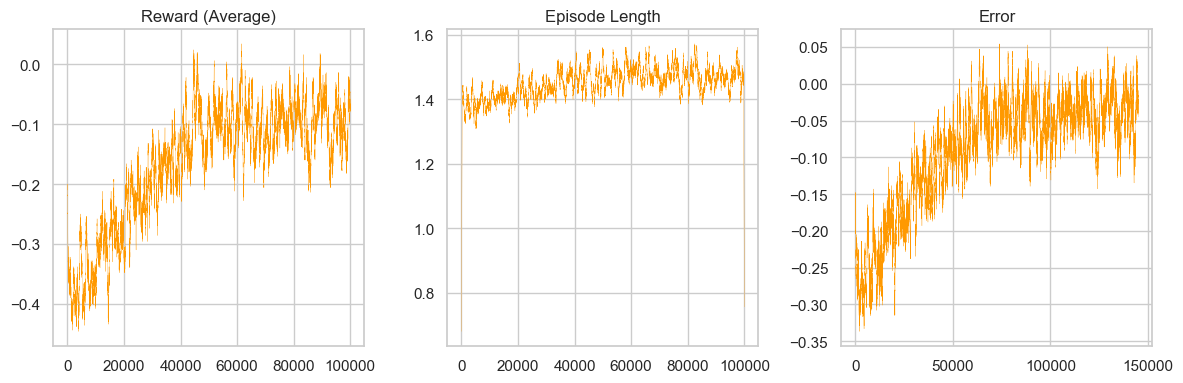

In [13]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], c='#FF9900', linewidth=.2)
ax[0].set_title('Reward (Average)')
sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], c='#FF9900', linewidth=.2)
ax[1].set_title('Episode Length')
sns.lineplot(x=range(len(error)), y=error, ax=ax[2], c='#FF9900', linewidth=.2)
ax[2].set_title('Error')
plt.tight_layout()
plt.show()

### Visualize policies
Nice plots taken from the [original tutorial](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)

In [14]:
from collections import defaultdict

In [15]:
def create_grids(agent, usable_ace=False):
    state_value, policy = defaultdict(float), defaultdict(int)
    for state, values in agent.Q.items():
        state_value[state] = np.max(values)
        policy[state] = int(np.argmax(values))
    # create a grid players_value x dealer face up value
    player, dealer = np.meshgrid(np.arange(11, 22), np.arange(1, 11))
    table = np.dstack([player, dealer])
    # create value grid
    value = np.apply_along_axis(
        lambda state: state_value[(state[0], state[1], usable_ace)],
        axis=2,
        arr=table
    )
    value_grid = player, dealer, value
    # create policy grid
    policy_grid = np.apply_along_axis(
        lambda state: policy[(state[0], state[1], usable_ace)],
        axis=2,
        arr=table
    )
    return value_grid, policy_grid

**Values and policy with usable Ace**

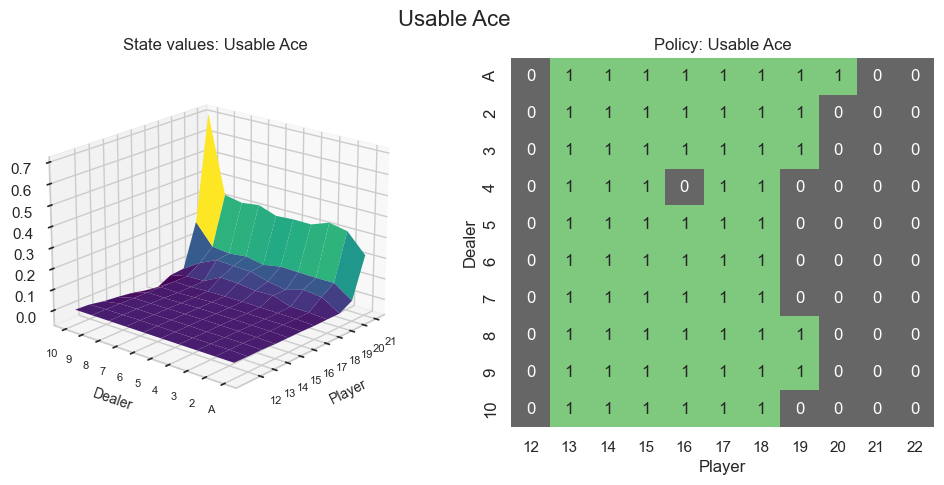

In [17]:
(player, dealer, value), policy_grid = create_grids(agent=agent, usable_ace=True)

fig = plt.figure(figsize=plt.figaspect(0.4))
title = 'Usable Ace'
fig.suptitle(title, fontsize=16)

# Values
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(player, dealer, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
plt.xticks(range(12, 22), range(12, 22), fontsize=8)
plt.yticks(range(1, 11), ["A"] + list(range(2, 11)), fontsize=8)
ax1.set_title(f"State values: {title}")
ax1.set_xlabel("Player", fontsize=10)
ax1.set_ylabel("Dealer", fontsize=10)
ax1.zaxis.set_rotate_label(False)
ax1.set_zlabel("Value", fontsize=10, rotation=90)
ax1.view_init(20, 220)

# Policy
fig.add_subplot(1, 2, 2)
ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
ax2.set_title(f"Policy: {title}")
ax2.set_xlabel("Player")
ax2.set_ylabel("Dealer")
#ax2.set_xticks(range(1,11))
ax2.set_xticklabels(range(12, 23))
ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
plt.show()

**Values and policy without usable Ace**

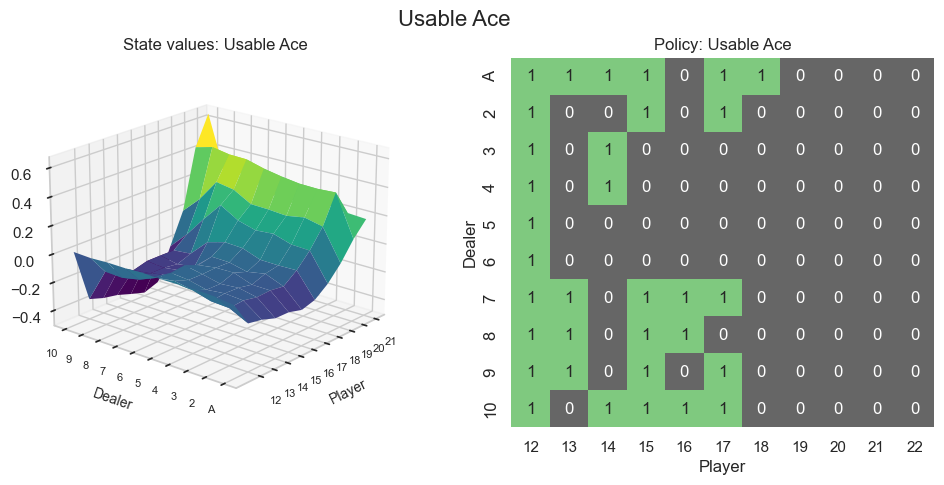

In [18]:
(player, dealer, value), policy_grid = create_grids(agent=agent, usable_ace=False)

fig = plt.figure(figsize=plt.figaspect(0.4))
title = 'Usable Ace'
fig.suptitle(title, fontsize=16)

# Values
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(player, dealer, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
plt.xticks(range(12, 22), range(12, 22), fontsize=8)
plt.yticks(range(1, 11), ["A"] + list(range(2, 11)), fontsize=8)
ax1.set_title(f"State values: {title}")
ax1.set_xlabel("Player", fontsize=10)
ax1.set_ylabel("Dealer", fontsize=10)
ax1.zaxis.set_rotate_label(False)
ax1.set_zlabel("Value", fontsize=10, rotation=90)
ax1.view_init(20, 220)

# Policy
fig.add_subplot(1, 2, 2)
ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
ax2.set_title(f"Policy: {title}")
ax2.set_xlabel("Player")
ax2.set_ylabel("Dealer")
#ax2.set_xticks(range(1,11))
ax2.set_xticklabels(range(12, 23))
ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
plt.show()